## Modelos de Decomposição de Irradiância
1) Erbs
2) Disc
3) Boland
4) Dirint
5) Dirindex
6) Erbs-Driesse
7) Orgill-Holands
8) Louche

In [1]:
#Libraries
import pvlib
from pvlib import pvsystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pvlib.pvsystem import calcparams_pvsyst, max_power_point
from timeit import timeit
import matplotlib.dates as mdates
import datetime as dt

In [70]:
# Location
latitude = 44.0446
longitude = -123.0726
altitude = 123.0
loc = pvlib.location.Location(latitude, longitude, altitude=altitude, tz='Etc/GMT+8')


In [84]:
# In-Field Data
df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UOSMRL',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20211231'))   # End date  YYYYMMDD

df_weather = df_weather[['Global CMP22 [W/m^2]', 'Diffuse [W/m^2]',
                         'Direct CHP1 [W/m^2]','Air Temperature [deg C]', 'Avg Wind Speed @ 10m [m/s]', 'Station Pressure [mBar]', 
                         'Zenith Angle [degrees]']]
# Rename the columns
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed', 'air_pressure', 'teta_z']

In [85]:
df_weather = df_weather.resample('h').mean().copy()
df_weather

,ghi,dhi,dni,temp_air,wind_speed,air_pressure,teta_z
2021-01-01 00:00:00-08:00,0.172967,-0.937967,0.290133,9.047333,1.949400,1000.285900,158.449320
2021-01-01 01:00:00-08:00,0.551333,-0.913817,0.212067,8.927167,1.143517,999.679667,153.902160
2021-01-01 02:00:00-08:00,0.523533,-0.879000,0.184817,9.061000,1.457500,999.444483,145.406816
2021-01-01 03:00:00-08:00,0.539867,-0.853700,0.173650,9.194500,1.255150,998.782800,135.274310
2021-01-01 04:00:00-08:00,0.579400,-0.901433,0.163283,9.193000,0.996417,998.276183,124.590551
...,...,...,...,...,...,...,...
2021-12-31 19:00:00-08:00,0.100083,-2.144600,0.083050,1.908283,0.253817,998.759583,118.774743
2021-12-31 20:00:00-08:00,0.422283,-1.928067,0.090617,1.744483,0.208117,999.651483,129.520205
2021-12-31 21:00:00-08:00,0.350667,-2.024783,0.043050,1.630100,0.572167,1000.255833,140.034936
2021-12-31 22:00:00-08:00,0.315400,-1.875650,0.092067,0.953533,0.561700,1000.835833,149.613575


In [86]:
# Decomposition Models
from pvlib import irradiance

solpos = loc.get_solarposition(df_weather.index)
clearsky = loc.get_clearsky(df_weather.index, model='ineichen', solar_position=solpos)
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)

# ERBS
out_erbs = irradiance.erbs(df_weather['ghi'], solpos['zenith'], df_weather.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

# DISC
out_disc = irradiance.disc(
    df_weather['ghi'], solpos.zenith, df_weather.index, df_weather['air_pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=df_weather['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

# BOLAND
out_boland = irradiance.boland(df_weather['ghi'], solpos.zenith, df_weather.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

# DIRINT
dni_dirint = irradiance.dirint(
    df_weather['ghi'], solpos.zenith, df_weather.index, df_weather['air_pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=df_weather['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=df_weather.index)

# DIRINDEX
dni_dirindex = irradiance.dirindex(
    df_weather['ghi'], clearsky['ghi'], clearsky['dni'], solpos.zenith, df_weather.index,
    pressure=df_weather['air_pressure']*100, use_delta_kt_prime=True, temp_dew=None,
    min_cos_zenith=0.065, max_zenith=87)
df_dirindex = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=df_weather['ghi'], dni=dni_dirindex,
    dhi=None)
out_dirindex = pd.DataFrame(
    {'dni_dirindex': dni_dirindex, 'dhi_dirindex': df_dirindex.dhi},
    index=df_weather.index)

# ERBS-DRIESSE
out_erbs_driesse = irradiance.erbs_driesse(df_weather['ghi'], solpos['zenith'], 
                                                 datetime_or_doy=None, dni_extra=dni_extra, 
                                                 min_cos_zenith=0.065, max_zenith=87)
out_erbs_driesse = out_erbs_driesse.rename(columns={'dni': 'dni_erbs_driesse', 'dhi': 'dhi_erbs_driesse'})

# ORGILL-HOLLANDS
out_orgill_hollands = irradiance.orgill_hollands(df_weather['ghi'], solpos['zenith'], 
                                                 datetime_or_doy = None, dni_extra=dni_extra, 
                                                 min_cos_zenith=0.065, max_zenith=87)
out_orgill_hollands = pd.DataFrame(
    {'dni_orgill_hollands': out_orgill_hollands['dni'], 'dhi_orgill_hollands': out_orgill_hollands['dhi'], 'kt': out_orgill_hollands['kt']}, index=df_weather.index)

# LOUCHE
out_louche = irradiance.louche(df_weather['ghi'], solpos['zenith'], datetime_or_doy=df_weather.index, max_zenith=90)
out_louche = out_louche.rename(columns={'dni': 'dni_louche', 'dhi': 'dhi_louche', 'kt': 'kt_louche'})


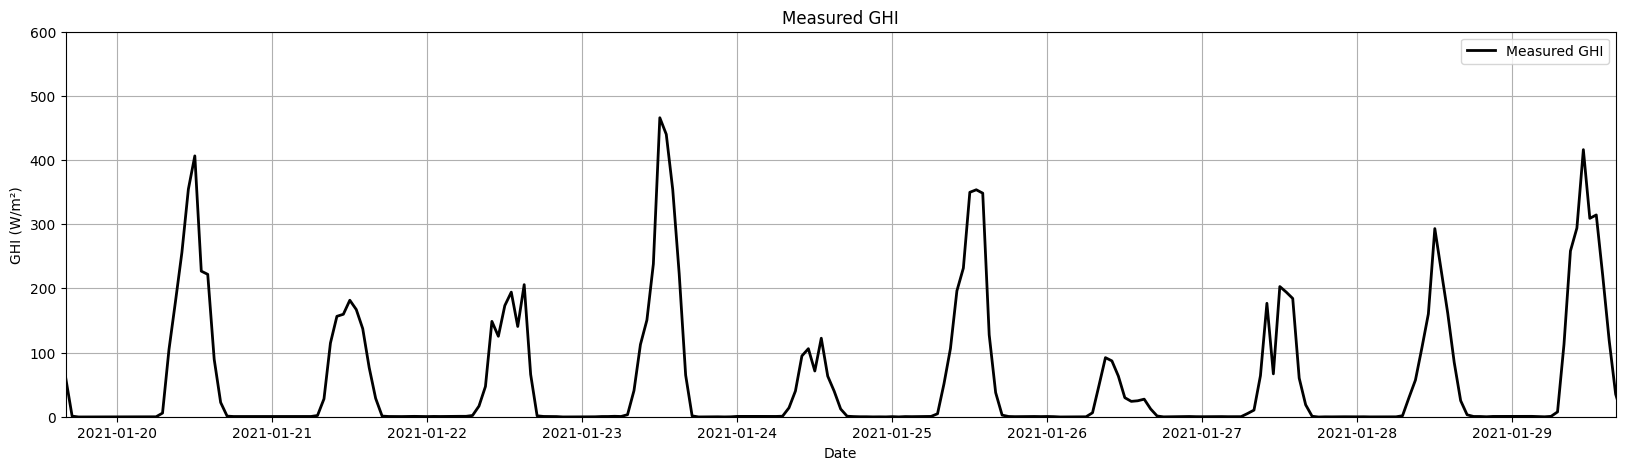

In [96]:
plt.figure(figsize=(20,5))
time_range = pd.date_range(start='2021-01-20', end='2021-01-30', freq='h')
plt.xlim([time_range[0], time_range[-1]])
plt.ylim([0, 600])
plt.plot(df_weather.index, df_weather['ghi'], label='Measured GHI', color='black', linewidth=2)
plt.xlabel('Date')
plt.ylabel('GHI (W/m²)')
plt.title('Measured GHI')
plt.legend()
plt.grid()

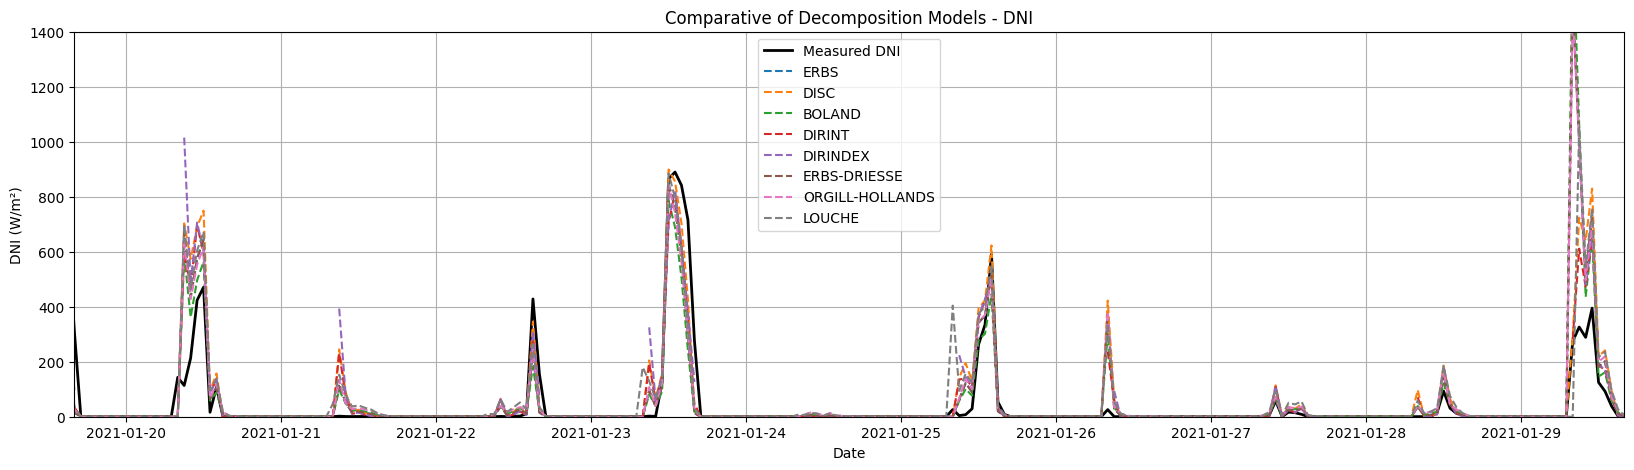

In [94]:
# Comparative Plots DNI
plt.figure(figsize=(20,5))
time_range = pd.date_range(start='2021-01-20', end='2021-01-30', freq='h')
plt.xlim([time_range[0], time_range[-1]])
plt.ylim([0, 1400])
plt.plot(df_weather.index, df_weather['dni'], label='Measured DNI', color='black', linewidth=2)
plt.plot(out_erbs.index, out_erbs['dni_erbs'], label='ERBS', linestyle='--')
plt.plot(out_disc.index, out_disc['dni_disc'], label='DISC', linestyle='--')
plt.plot(out_boland.index, out_boland['dni_boland'], label='BOLAND', linestyle='--')
plt.plot(out_dirint.index, out_dirint['dni_dirint'], label='DIRINT', linestyle='--')
plt.plot(out_dirindex.index, out_dirindex['dni_dirindex'], label='DIRINDEX', linestyle='--')
plt.plot(out_erbs_driesse.index, out_erbs_driesse['dni_erbs_driesse'], label='ERBS-DRIESSE', linestyle='--')
plt.plot(out_orgill_hollands.index, out_orgill_hollands['dni_orgill_hollands'], label='ORGILL-HOLLANDS', linestyle='--')
plt.plot(out_louche.index, out_louche['dni_louche'], label='LOUCHE', linestyle='--')
plt.xlabel('Date')
plt.ylabel('DNI (W/m²)')
plt.title('Comparative of Decomposition Models - DNI')
plt.legend()
plt.grid()

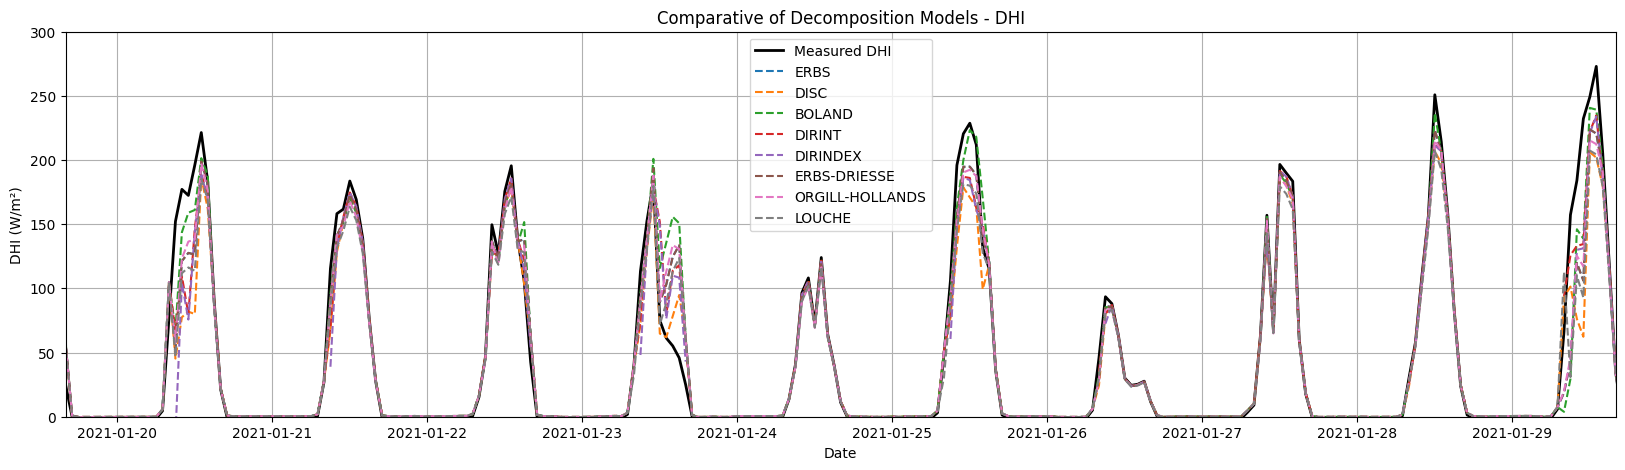

In [95]:
# Comparative Plots DHI
plt.figure(figsize=(20,5))
time_range = pd.date_range(start='2021-01-20', end='2021-01-30', freq='h')
plt.xlim([time_range[0], time_range[-1]])
plt.ylim([0, 300])
plt.plot(df_weather.index, df_weather['dhi'], label='Measured DHI', color='black', linewidth=2)
plt.plot(out_erbs.index, out_erbs['dhi_erbs'], label='ERBS', linestyle='--')
plt.plot(out_disc.index, out_disc['dhi_disc'], label='DISC', linestyle='--')
plt.plot(out_boland.index, out_boland['dhi_boland'], label='BOLAND', linestyle='--')
plt.plot(out_dirint.index, out_dirint['dhi_dirint'], label='DIRINT', linestyle='--')
plt.plot(out_dirindex.index, out_dirindex['dhi_dirindex'], label='DIRINDEX', linestyle='--')
plt.plot(out_erbs_driesse.index, out_erbs_driesse['dhi_erbs_driesse'], label='ERBS-DRIESSE', linestyle='--')
plt.plot(out_orgill_hollands.index, out_orgill_hollands['dhi_orgill_hollands'], label='ORGILL-HOLLANDS', linestyle='--')
plt.plot(out_louche.index, out_louche['dhi_louche'], label='LOUCHE', linestyle='--')
plt.xlabel('Date')
plt.ylabel('DHI (W/m²)')
plt.title('Comparative of Decomposition Models - DHI')
plt.legend()
plt.grid()